# Review to 5 star pipeline

## Using a llm to create input numbers as features for ML algorithms later down the pipeline. 

The selected llm is not able to create 5 star reviews directly. Therefore we'll use it for feature generation. The other caveat is that the model was trained for Amazon reviews (positive/negative). But we are confident, that the created targets will be useful in the Airbnb 5 star assessment.

In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "sohan-ai/sentiment-analysis-model-amazon-reviews"
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(model_name)

import pandas as pd 

In [2]:
df = pd.read_csv('../data/machine_learning/kaggle_data_reduced.csv.gz', compression='gzip')


In [3]:
df.head()

,Review,Rating,Origin
0,nice hotel expensive parking got good deal sta...,4,thedevastator
1,ok nothing special charge diamond member hilto...,2,thedevastator
2,nice rooms not 4* experience hotel monaco seat...,3,thedevastator
3,unique \tgreat stay \twonderful time hotel mon...,5,thedevastator
4,great stay great stay \twent seahawk game awes...,5,thedevastator


## Examples

In [90]:
def print_label_and_logits(text):
    print(text)
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predicted_label = "positive" if outputs.logits.argmax().item() == 1 else "negative"
    logits = outputs.logits.detach().numpy()
    print(logits)

print_label_and_logits("What a shitty room.")
print_label_and_logits("I loved the whole area.")
print_label_and_logits("Some was good and some was bad.")

What a shitty room.
[[ 1.7646039 -1.7241373]]
I loved the whole area.
[[-2.4363034  2.4713895]]
Some was good and some was bad.
[[ 0.59663886 -0.6075468 ]]


In [91]:
df.Review

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique \tgreat stay \twonderful time hotel mon...
4        great stay great stay \twent seahawk game awes...
                               ...                        
41976    best kept secret 3rd time staying charm, not 5...
41977    great location price view hotel great quick pl...
41978    ok just looks nice modern outside, desk staff ...
41979    hotel theft ruined vacation hotel opened sept ...
41980    people talking, ca n't believe excellent ratin...
Name: Review, Length: 41981, dtype: object

In [4]:
def add_sentiment_features(row):
    text = row['Review']
    inputs = tokenizer(text, return_tensors="pt")
    
    outputs = model(**inputs)
    logits = outputs.logits.detach().numpy()
    return logits[0][0], logits[0][1]

    

In [7]:
df['Review'] = df['Review'].apply(lambda x: x[:512] if len(x) > 512 else x)

df['feature_1'], df['feature_2'] = zip(*df.apply(add_sentiment_features, axis=1))

In [9]:
df.to_csv('kaggle_data_reduced_enriched.csv.gz', compression='gzip', index=False)

In [11]:
df = pd.read_csv('kaggle_data_reduced_enriched.csv.gz', compression='gzip')

### Sample check

In [17]:
df.head(20)

,Review,Rating,Origin,feature_1,feature_2
0,nice hotel expensive parking got good deal sta...,4,thedevastator,1.226591,-1.141270
1,ok nothing special charge diamond member hilto...,2,thedevastator,1.961799,-1.924461
2,nice rooms not 4* experience hotel monaco seat...,3,thedevastator,1.532970,-1.514355
3,unique \tgreat stay \twonderful time hotel mon...,5,thedevastator,-2.233017,2.234149
4,great stay great stay \twent seahawk game awes...,5,thedevastator,-0.810025,0.717870
5,love monaco staff husband stayed hotel crazy w...,5,thedevastator,-1.774060,1.732892
6,cozy stay rainy city \thusband spent 7 nights ...,5,thedevastator,-2.544452,2.578069
7,excellent staff \thousekeeping quality hotel c...,4,thedevastator,-2.103502,2.095607
8,hotel stayed hotel monaco cruise \trooms gener...,5,thedevastator,-1.813200,1.774499
9,excellent stayed hotel monaco past w/e delight...,5,thedevastator,-2.214024,2.216177


### Correlation check

In [16]:
df[['Rating','feature_1','feature_2']].corr()


,Rating,feature_1,feature_2
Rating,1.000000,-0.731518,0.728809
feature_1,-0.731518,1.000000,-0.999635
feature_2,0.728809,-0.999635,1.000000


The most important finding here is that both features correlate with the target. We can therefore hope that traditional machine learning algorithms will be able to create decent results. Since feature_1 and feature_2 are so strongly correlated, I'll drop one of them. Since feature_2 is positively correlated with the target I will keep it since this makes the relationship more intuitive.

## Machine Learing for 5 star review

In [ ]:
!pip install xgboost

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import pickle

### Random Forest

In [71]:
X = df.drop(columns=['Rating','Review','Origin','feature_1'])
y = df.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.head()

,feature_2
26129,-3.036528
26369,2.416714
17932,-2.402971
29870,2.019817
39378,0.545442


In [72]:
number_of_trees = range(4, 60, 4)
train_rmses = []
test_rmses = []

for n in number_of_trees:
    rfc = RandomForestClassifier(n)
    rfc.fit(X_train, y_train)
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
                     
    rmse_train = mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_train)
    print(f'Train RMSE: {rmse_train}')
    
    rmse_test = mean_squared_error(y_test, y_test_pred)
    test_rmses.append(rmse_test)
    print(f'Test RMSE: {rmse_test}')


Train RMSE: 0.303477846593616
Test RMSE: 1.3345242348457782
Train RMSE: 0.15918294425917104
Test RMSE: 1.3147552697391927
Train RMSE: 0.09805264411624583
Test RMSE: 1.299392640228653
Train RMSE: 0.06571581705574082
Test RMSE: 1.3047516970346553
Train RMSE: 0.046748451643639825
Test RMSE: 1.3004644515898536
Train RMSE: 0.03841114816579323
Test RMSE: 1.3021317137072763
Train RMSE: 0.02572653644592663
Test RMSE: 1.2960581159938074
Train RMSE: 0.017806098141972367
Test RMSE: 1.3011789924973205
Train RMSE: 0.015483563601715102
Test RMSE: 1.2991544599261642
Train RMSE: 0.010630061934254406
Test RMSE: 1.3023698940097654
Train RMSE: 0.008515959980943306
Test RMSE: 1.3051089674883887
Train RMSE: 0.008277751310147689
Test RMSE: 1.3043944265809218
Train RMSE: 0.00687827536922344
Test RMSE: 1.2943908538763844
Train RMSE: 0.006729394949976179
Test RMSE: 1.2990353697749195


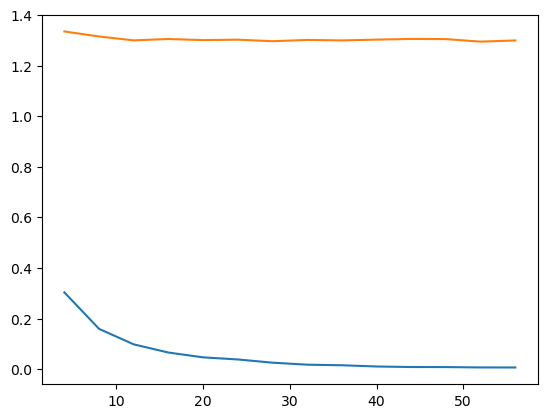

In [73]:
plt.plot(number_of_trees, train_rmses)
plt.plot(number_of_trees, test_rmses)
plt.show()


In [74]:
X = df.drop(columns=['Rating','Review','Origin'])
y = df.Rating

y = y - 1 # Needed since XGBoost is zero based

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.head()

,feature_1,feature_2
26129,3.173402,-3.036528
26369,-2.394686,2.416714
17932,2.458180,-2.402971
29870,-2.028114,2.019817
39378,-0.619453,0.545442


In [98]:
number_of_trees = range(4, 60, 4)
train_rmses = []
test_rmses = []

for n in number_of_trees:
    rfc = RandomForestClassifier(n, max_depth=8)
    rfc.fit(X_train, y_train)
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
                     
    rmse_train = mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_train)
    print(f'Train RMSE: {rmse_train}')
    
    rmse_test = mean_squared_error(y_test, y_test_pred)
    test_rmses.append(rmse_test)
    print(f'Test RMSE: {rmse_test}')

Train RMSE: 0.9885064316341114
Test RMSE: 1.06097415743718
Train RMSE: 0.9964864221057647
Test RMSE: 1.0585923544122902
Train RMSE: 1.0033944735588376
Test RMSE: 1.0674050256043826
Train RMSE: 0.9819259171033826
Test RMSE: 1.052995117303799
Train RMSE: 0.9973499285373988
Test RMSE: 1.0498987733714422
Train RMSE: 0.9915138161029061
Test RMSE: 1.054186018816244
Train RMSE: 0.9921093377798952
Test RMSE: 1.0394188400619269
Train RMSE: 0.9872558361124345
Test RMSE: 1.0539478385137548
Train RMSE: 0.9948487374940448
Test RMSE: 1.052518756698821
Train RMSE: 0.992228442115293
Test RMSE: 1.0544241991187329
Train RMSE: 1.0025607432110528
Test RMSE: 1.06097415743718
Train RMSE: 0.9867496426869938
Test RMSE: 1.0578778135048232
Train RMSE: 0.9876727012863268
Test RMSE: 1.0448969870191736
Train RMSE: 0.9865114340161982
Test RMSE: 1.0531142074550435


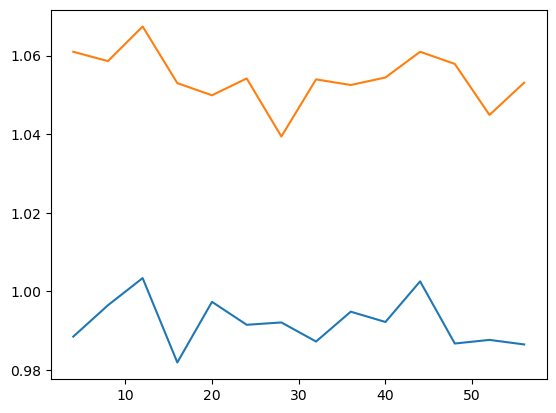

In [99]:
plt.plot(number_of_trees, train_rmses)
plt.plot(number_of_trees, test_rmses)
plt.show()

In [104]:
rfc = RandomForestClassifier(28, max_depth=8)
rfc.fit(X, y)

# Save the model to disk
with open('random_forest_kaggle_data_classifier.pkl', 'wb') as file:
    pickle.dump(rfc, file)



### XGBoost

In [84]:
number_of_trees = range(4, 60, 4)
train_rmses = []
test_rmses = []



for n in number_of_trees:
    xgb = XGBClassifier(objective='multi:softmax', num_class=5, max_depth=2, learning_rate=0.01, n_estimators=n)
    xgb.fit(X_train, y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
                     
    rmse_train = mean_squared_error(y_train, y_train_pred)
    train_rmses.append(rmse_train)
    print(f'Train RMSE: {rmse_train}')
    
    rmse_test = mean_squared_error(y_test, y_test_pred)
    test_rmses.append(rmse_test)
    print(f'Test RMSE: {rmse_test}')



Train RMSE: 1.0016972367794188
Test RMSE: 1.0110753840657378
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0122975226298236
Test RMSE: 1.039180659759438
Train RMSE: 1.0147987136731778
Test RMSE: 1.0423960938430392
Train RMSE: 1.0147987136731778
Test RMSE: 1.0423960938430392
Train RMSE: 1.0512148642210577
Test RMSE: 1.081814933904966
Train RMSE: 1.0607729871367317
Test RMSE: 1.0949148505418602
Train RMSE: 1.0607729871367317
Test RMSE: 1.0949148505418602
Train RMSE: 1.0607729871367317
Test RMSE: 1.0949148505418602


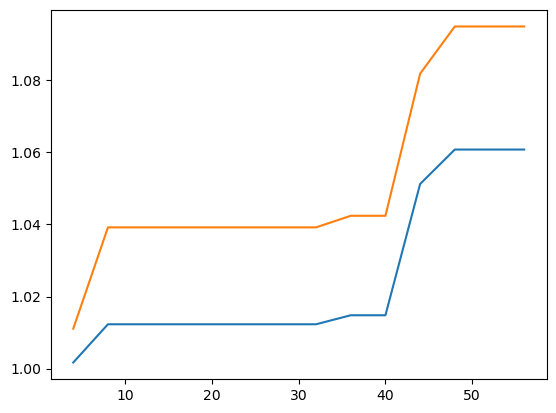

In [85]:
plt.plot(number_of_trees, train_rmses)
plt.plot(number_of_trees, test_rmses)
plt.show()

In [103]:
xgb = XGBClassifier(objective='multi:softmax', num_class=5, max_depth=2, learning_rate=0.01, n_estimators=4)
xgb.fit(X, y)



# Save the model to disk
with open('XGBoost_kaggle_data_classifier.pkl', 'wb') as file:
    pickle.dump(xgb, file)